In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# https://arxiv.org/pdf/2006.11239.pdf

import torch
from torch import optim, nn

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet, UNet_conditional
from torchvision.transforms import v2
from matplotlib import pyplot as plt

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

with open("labels/pokedex.json") as json_data:
    data = json.load(json_data)

height = [float(str(d['profile']['height']).split()[0]) for d in data]
height = torch.tensor(height, device=device)
#height

types = [d['type'] for d in data]
all_types = list(set([d[0] for d in types]))
types = torch.tensor([all_types.index(t[0]) for t in types], device=device)

#contour = load_contour().to(device)
#contour.shape

In [2]:
T = 100
beta = torch.linspace(0.09, 0.05, T, device=device)

alpha = 1 - beta

alpha_ = torch.zeros(T, device=device)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_[-1]

tensor(0.0007, device='cuda:0')

In [3]:
alpha_

tensor([9.1000e-01, 8.2847e-01, 7.5458e-01, 6.8758e-01, 6.2681e-01, 5.7166e-01,
        5.2160e-01, 4.7613e-01, 4.3482e-01, 3.9726e-01, 3.6312e-01, 3.3205e-01,
        3.0377e-01, 2.7803e-01, 2.5458e-01, 2.3321e-01, 2.1373e-01, 1.9596e-01,
        1.7975e-01, 1.6495e-01, 1.5144e-01, 1.3910e-01, 1.2781e-01, 1.1750e-01,
        1.0806e-01, 9.9428e-02, 9.1524e-02, 8.4285e-02, 7.7653e-02, 7.1574e-02,
        6.6000e-02, 6.0887e-02, 5.6194e-02, 5.1886e-02, 4.7929e-02, 4.4293e-02,
        4.0951e-02, 3.7878e-02, 3.5050e-02, 3.2448e-02, 3.0052e-02, 2.7845e-02,
        2.5812e-02, 2.3937e-02, 2.2208e-02, 2.0613e-02, 1.9141e-02, 1.7782e-02,
        1.6527e-02, 1.5366e-02, 1.4294e-02, 1.3302e-02, 1.2384e-02, 1.1535e-02,
        1.0748e-02, 1.0020e-02, 9.3448e-03, 8.7190e-03, 8.1386e-03, 7.6001e-03,
        7.1004e-03, 6.6363e-03, 6.2053e-03, 5.8048e-03, 5.4324e-03, 5.0862e-03,
        4.7641e-03, 4.4643e-03, 4.1851e-03, 3.9252e-03, 3.6829e-03, 3.4571e-03,
        3.2465e-03, 3.0501e-03, 2.8668e-

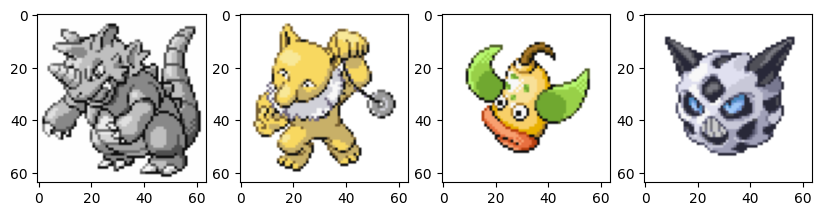

In [4]:
transform = v2.Compose([
    v2.RandomApply([v2.ColorJitter()], 0.2),
    v2.RandomApply([v2.RandomChannelPermutation()], 0.2),
    v2.RandomGrayscale(p = 0.2),
])

source = randint(0, 2)
batch = torch.randperm(385)[:4]
x0 = pimages[source, batch]
x0 = torch.stack([transform(x) for x in x0], dim=0)

fig, axes = plt.subplots(1, 4, figsize=(10, 10))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [5]:
def isigmoid(x):
    eps = 0.05
    return torch.log(x + eps) - torch.log(1 - x + eps)


In [6]:
model = UNet_conditional(3, 3, num_classes=len(all_types)).to(device)

@torch.no_grad
def generate_image():
    model.eval()

    N = 3

    x = torch.randn((N, 3, 64, 64), device=device)

    ty = ["Grass", "Fire", "Water"]
    ty = torch.tensor([all_types.index(t) for t in ty], device=device)
    #print(ty)

    for t in reversed(range(T)):
        tt = torch.tensor([t] * N, device=device)

        z = torch.randn_like(x)
        if t == 0:
            z *= 0

        #x0 = model(x, tt)
        #x = torch.sqrt(alpha_[t]) * x0 + torch.sqrt(1-alpha_[t]) * z

        e = model(x, tt, ty) * (1 - alpha[t]) / torch.sqrt(1 - alpha_[t])
        x = (1 / torch.sqrt(alpha[t])) * (x - e) + z * torch.sqrt(beta[t])
    
    x = torch.sigmoid(x)
    
    fig, axes = plt.subplots(1, N, figsize=(10, 10))
    for i in range(N):
        plot_image(x[i], axes[i])
    plt.show()

    model.train()

In [7]:
#sd = torch.load("model.pt")
#model.load_state_dict(sd)

#generate_image()

  0%|          | 0/100001 [00:00<?, ?it/s]

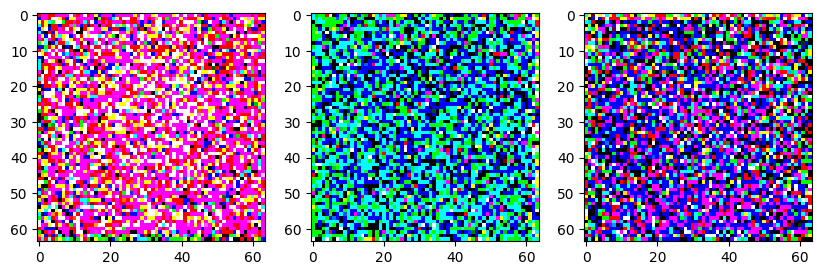

0.03854177:   1%|          | 999/100001 [01:26<2:20:13, 11.77it/s]

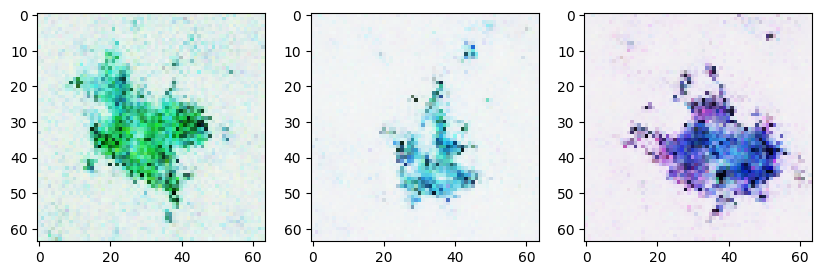

0.01810561:   2%|▏         | 1999/100001 [02:53<2:18:58, 11.75it/s]

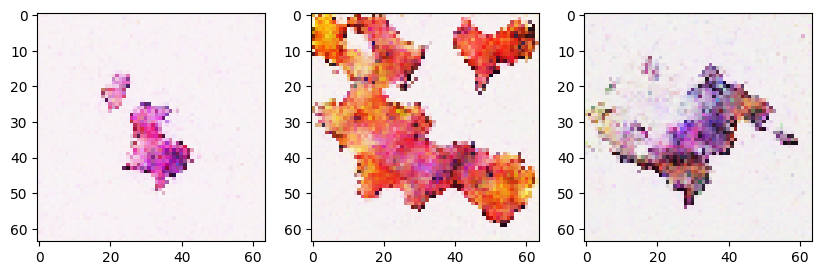

0.02528603:   3%|▎         | 2999/100001 [04:19<2:17:23, 11.77it/s]

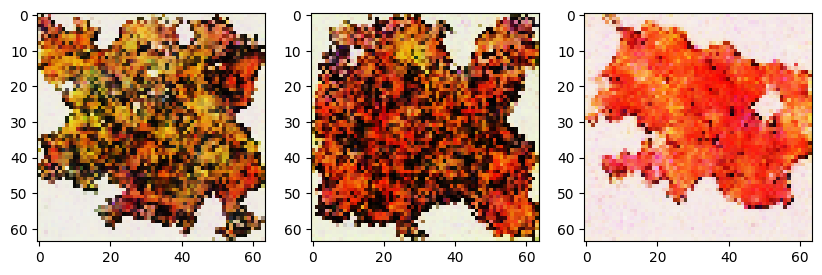

0.02103543:   4%|▍         | 3999/100001 [05:46<2:18:47, 11.53it/s]

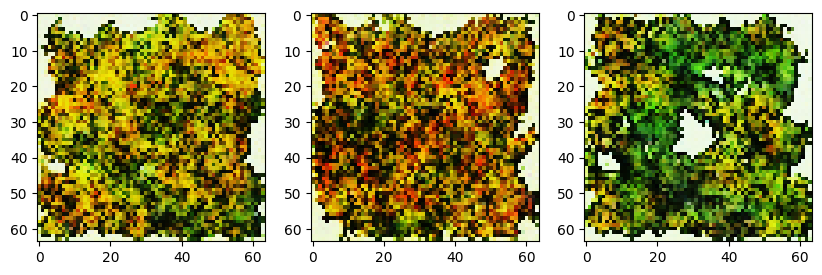

0.01687773:   5%|▍         | 4999/100001 [07:12<2:14:41, 11.76it/s]

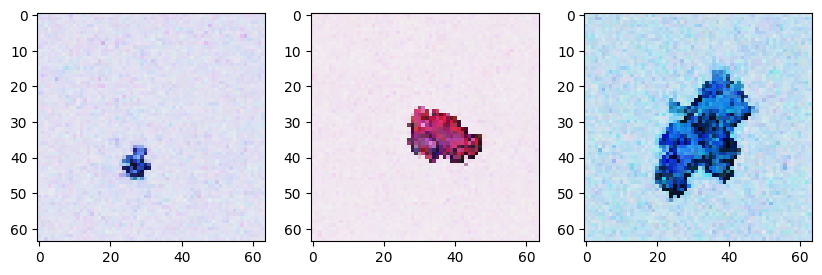

0.01567467:   6%|▌         | 5999/100001 [08:39<2:13:08, 11.77it/s]

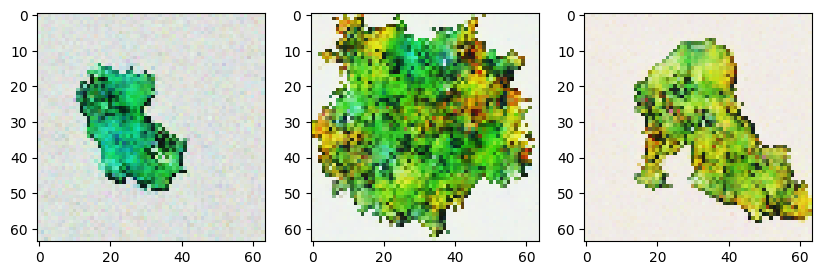

0.00968141:   7%|▋         | 6999/100001 [10:05<2:11:41, 11.77it/s]

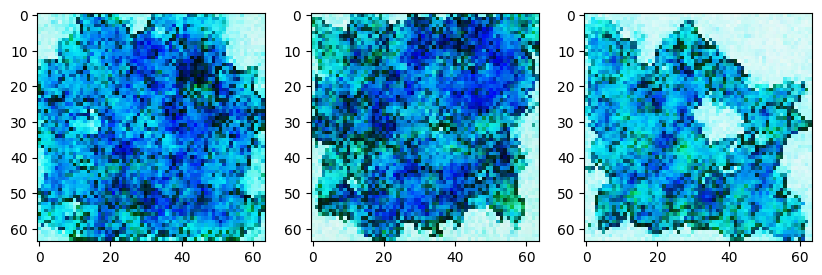

0.02019799:   8%|▊         | 7999/100001 [11:32<2:10:21, 11.76it/s]

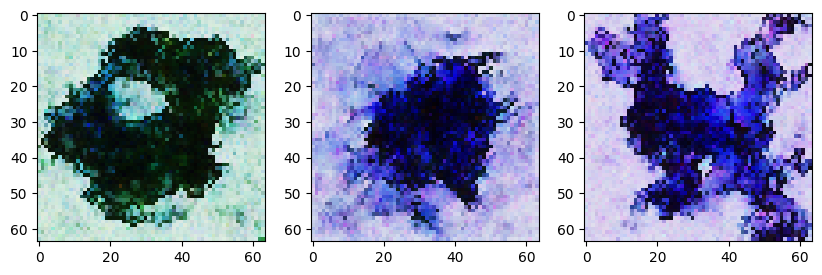

0.00819698:   9%|▉         | 8999/100001 [12:58<2:08:50, 11.77it/s]

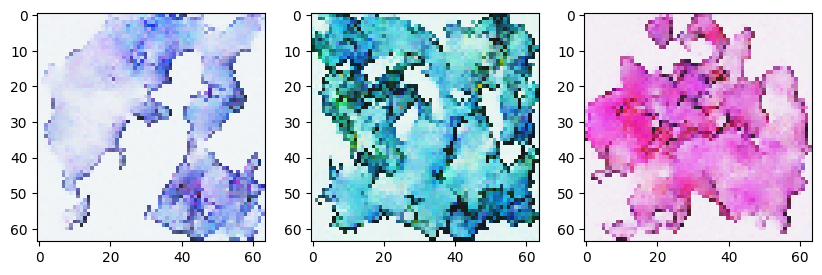

0.02127307:  10%|▉         | 9999/100001 [14:24<2:07:27, 11.77it/s]

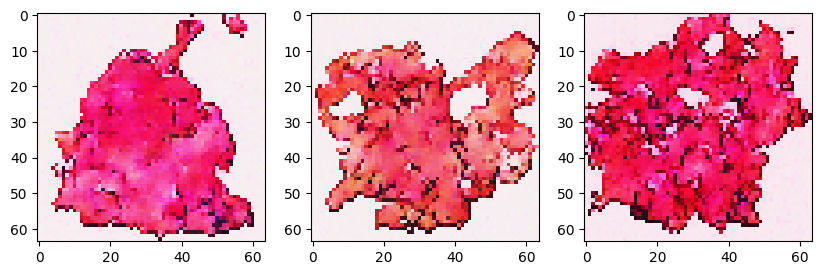

0.01671730:  11%|█         | 10999/100001 [15:51<2:06:04, 11.77it/s]

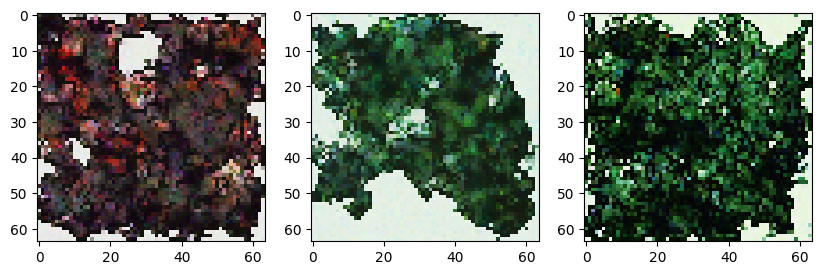

0.01250294:  12%|█▏        | 11999/100001 [17:17<2:04:43, 11.76it/s]

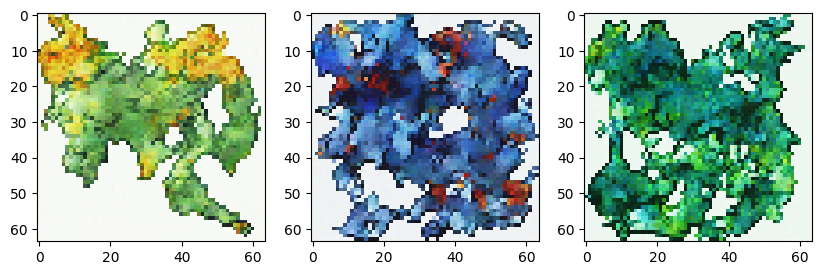

0.04237434:  13%|█▎        | 12999/100001 [18:44<2:03:17, 11.76it/s]

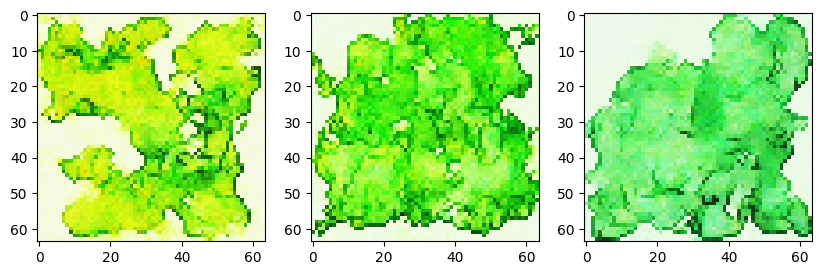

0.03192030:  14%|█▍        | 13999/100001 [20:10<2:01:44, 11.77it/s]

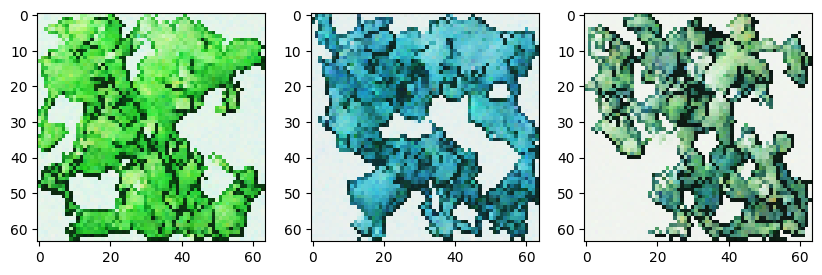

0.00339833:  15%|█▍        | 14999/100001 [21:36<2:00:22, 11.77it/s]

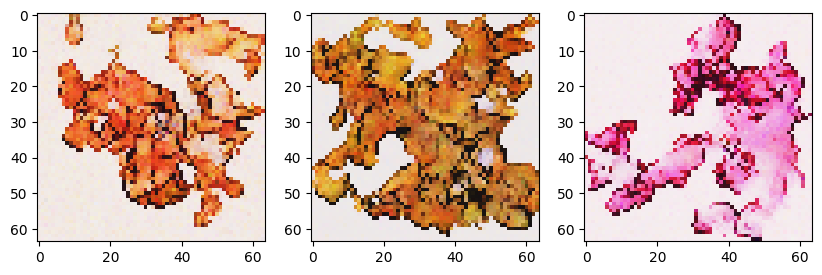

0.01811619:  16%|█▌        | 15999/100001 [23:03<1:58:57, 11.77it/s]

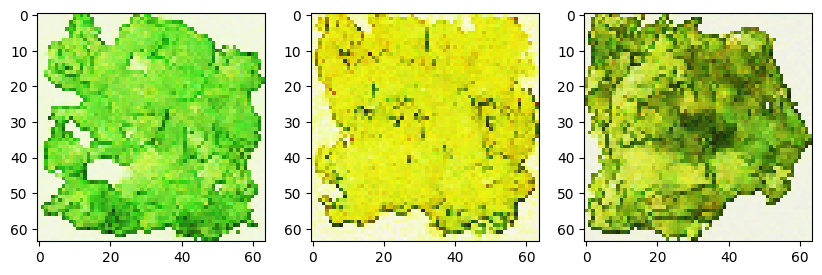

0.01412852:  17%|█▋        | 16999/100001 [24:29<1:57:31, 11.77it/s]

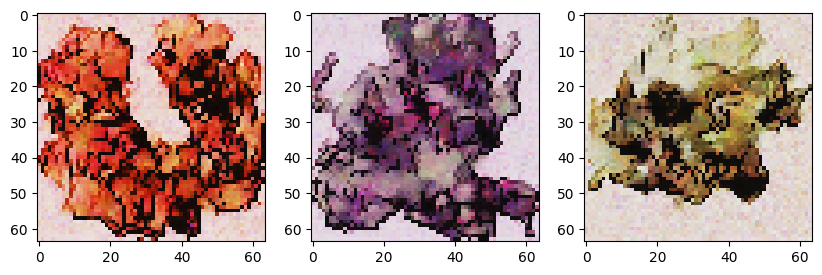

0.03627786:  18%|█▊        | 17999/100001 [25:56<1:56:14, 11.76it/s]

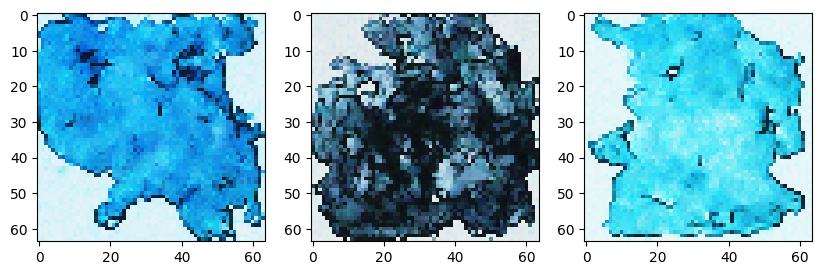

0.01645034:  19%|█▉        | 18999/100001 [27:22<1:54:44, 11.77it/s]

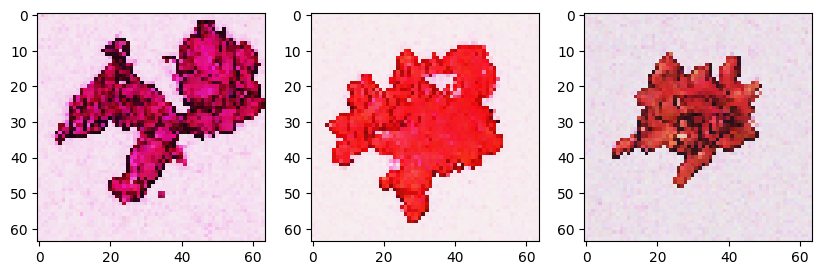

0.02386227:  20%|█▉        | 19999/100001 [28:49<1:53:20, 11.76it/s]

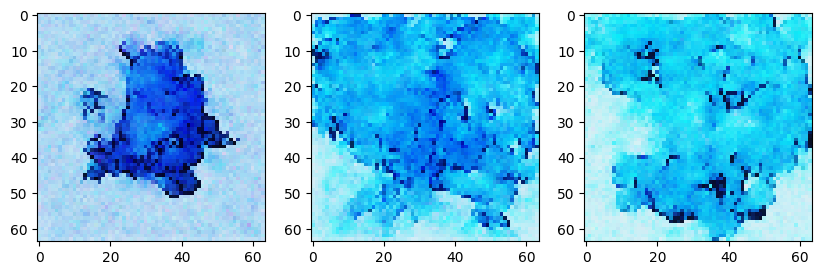

0.02611533:  21%|██        | 20999/100001 [30:15<1:52:11, 11.74it/s]

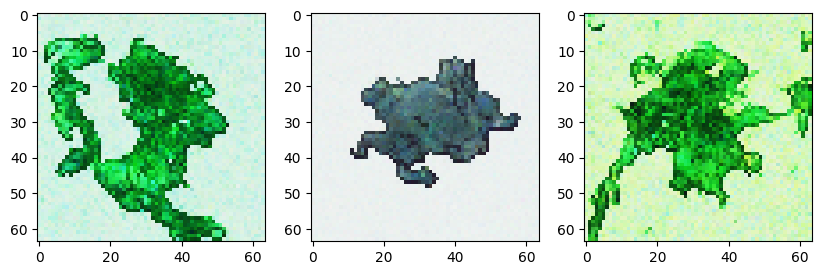

0.02738579:  22%|██▏       | 21999/100001 [31:42<1:50:36, 11.75it/s]

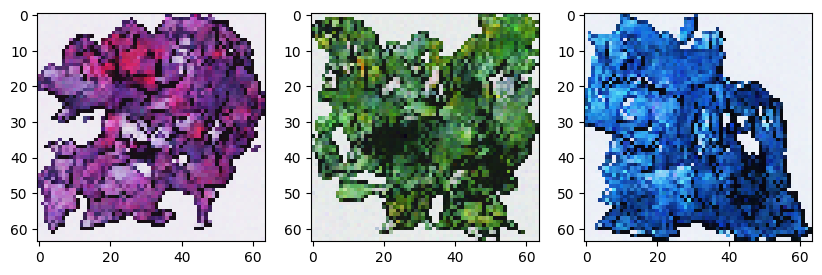

0.01833943:  23%|██▎       | 22999/100001 [33:08<1:49:02, 11.77it/s]

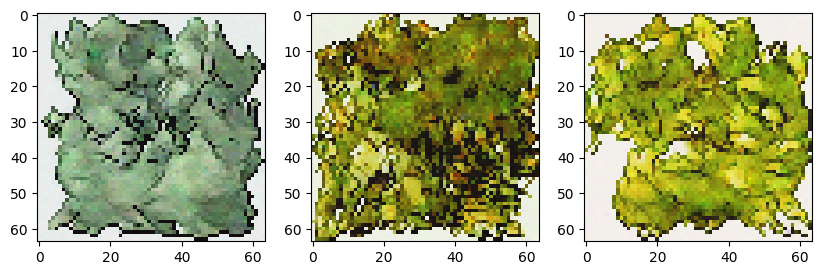

0.01981276:  24%|██▍       | 23999/100001 [34:35<1:47:41, 11.76it/s]

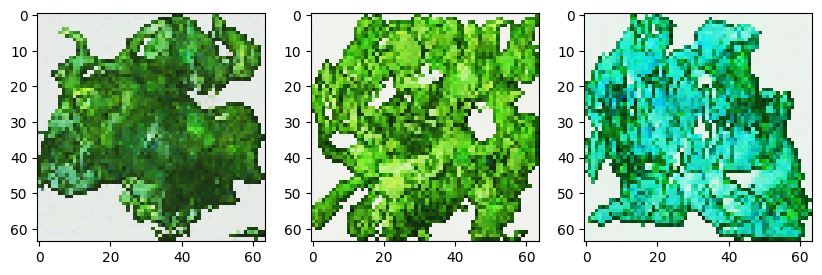

0.01820896:  25%|██▍       | 24999/100001 [36:01<1:46:11, 11.77it/s]

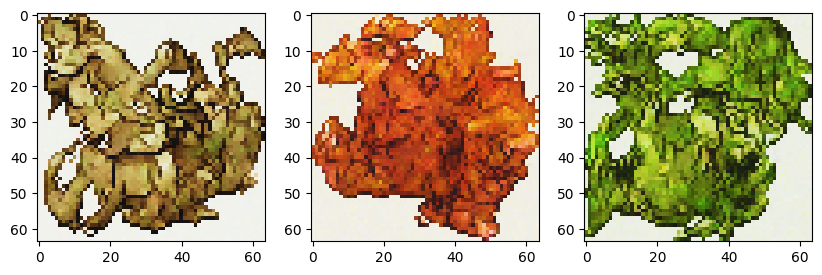

0.01469763:  26%|██▌       | 25999/100001 [37:28<1:44:53, 11.76it/s]

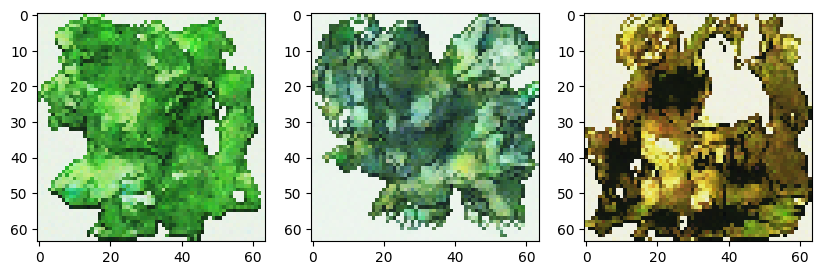

0.02468080:  27%|██▋       | 26999/100001 [38:54<1:43:19, 11.78it/s]

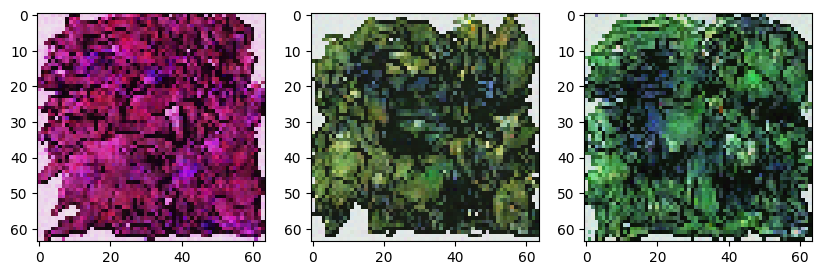

0.02048477:  28%|██▊       | 27999/100001 [40:21<1:42:00, 11.76it/s]

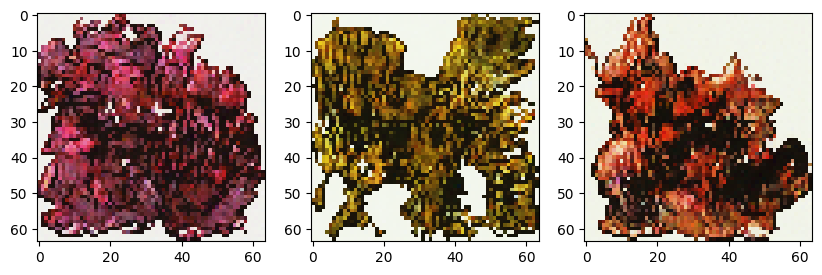

0.01175349:  29%|██▉       | 28999/100001 [41:47<1:40:33, 11.77it/s]

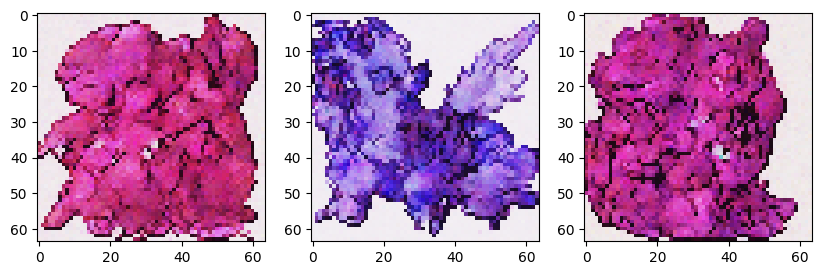

0.00654298:  30%|██▉       | 29999/100001 [43:14<1:39:11, 11.76it/s]

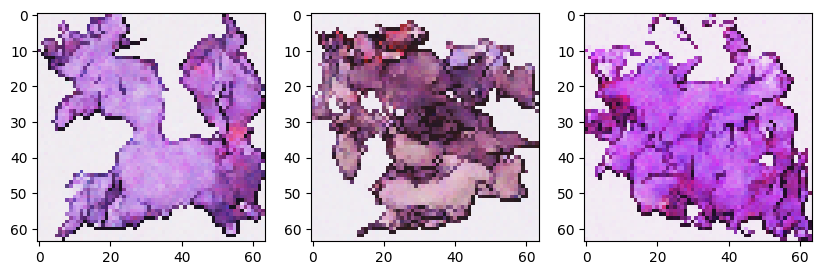

0.01676838:  31%|███       | 30999/100001 [44:40<1:37:44, 11.77it/s]

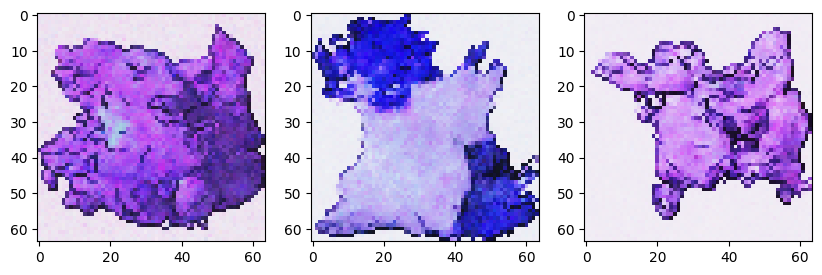

0.01537320:  32%|███▏      | 31999/100001 [46:06<1:36:21, 11.76it/s]

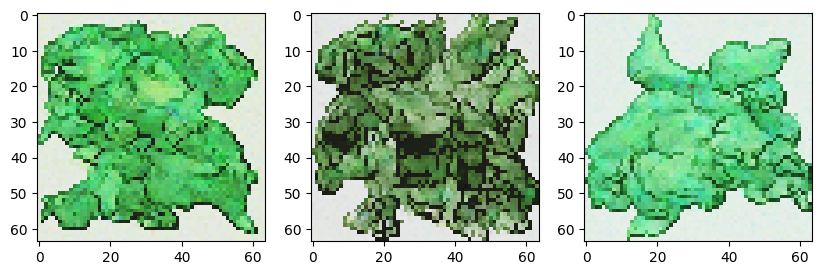

0.03014064:  33%|███▎      | 32999/100001 [47:33<1:34:53, 11.77it/s]

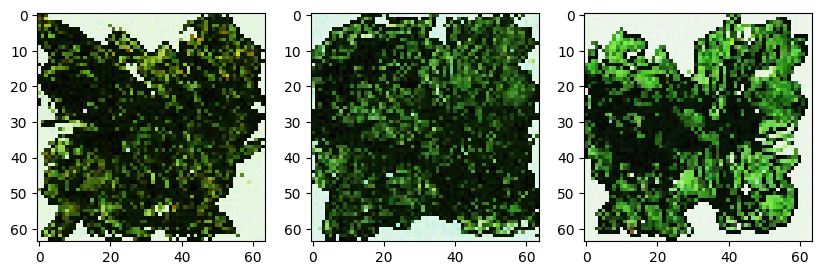

0.00747695:  34%|███▍      | 33999/100001 [48:59<1:33:34, 11.76it/s]

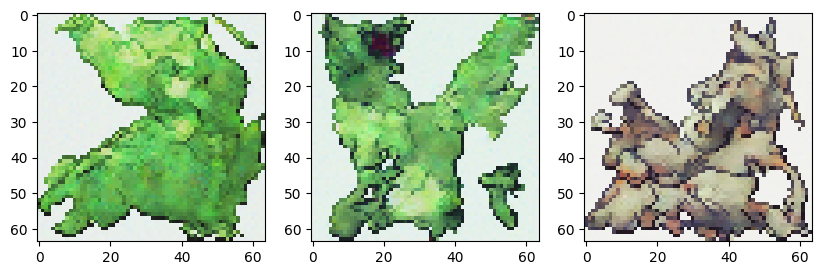

0.01675865:  35%|███▍      | 34999/100001 [50:26<1:32:01, 11.77it/s]

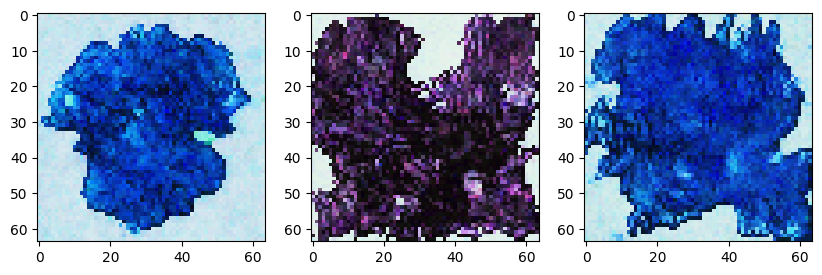

0.02084498:  36%|███▌      | 35999/100001 [51:52<1:30:40, 11.76it/s]

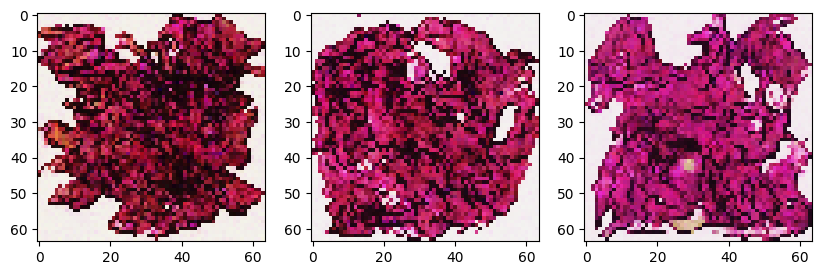

0.01414642:  37%|███▋      | 36999/100001 [53:19<1:29:10, 11.77it/s]

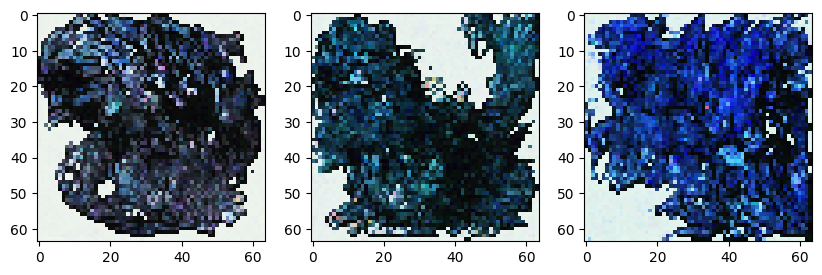

0.00814718:  38%|███▊      | 37999/100001 [54:45<1:27:49, 11.77it/s]

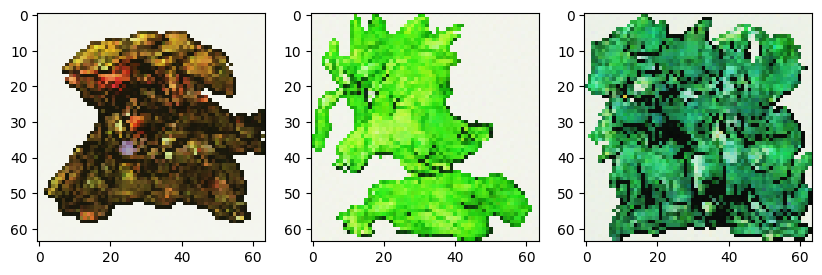

0.01143808:  39%|███▉      | 38999/100001 [56:11<1:26:33, 11.75it/s]

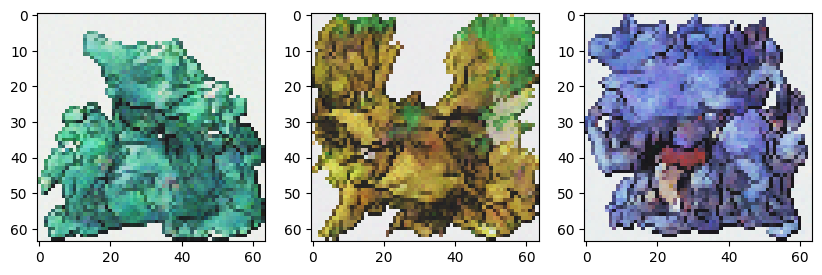

0.01821616:  40%|███▉      | 39999/100001 [57:38<1:25:04, 11.76it/s]

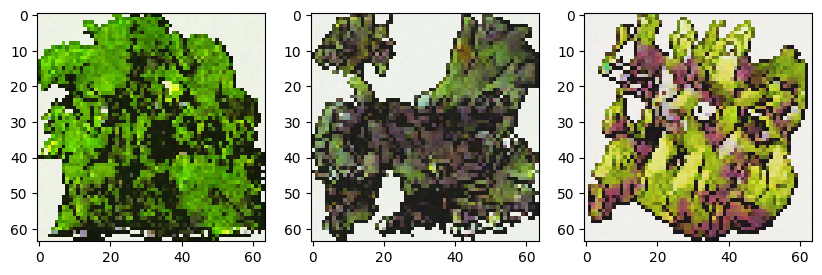

0.02330605:  41%|████      | 40999/100001 [59:04<1:23:39, 11.76it/s]

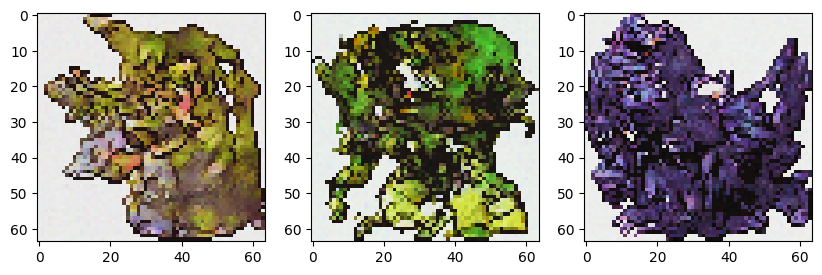

0.01946184:  42%|████▏     | 41999/100001 [1:00:31<1:22:06, 11.77it/s]

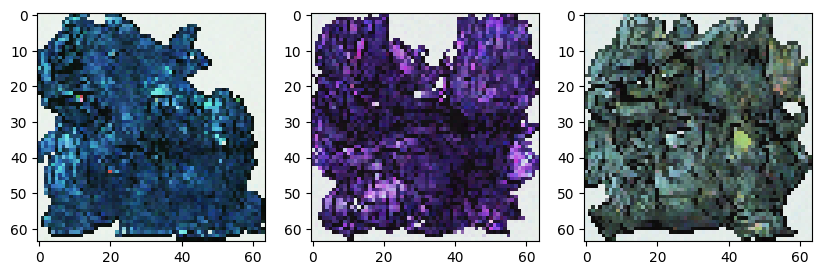

0.01857631:  43%|████▎     | 42999/100001 [1:01:57<1:20:44, 11.77it/s]

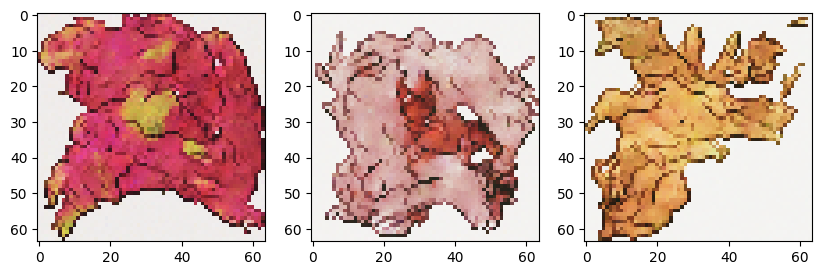

0.01097860:  44%|████▍     | 43999/100001 [1:03:24<1:19:21, 11.76it/s]

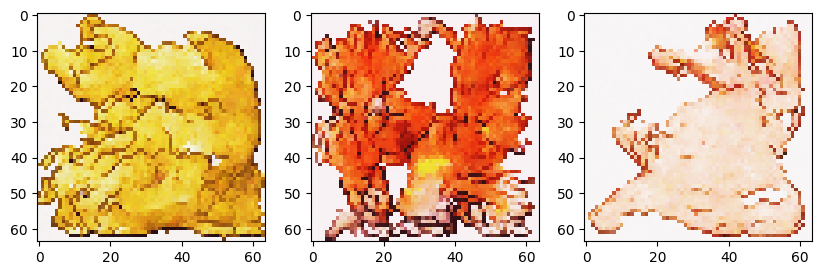

0.02007414:  45%|████▍     | 44999/100001 [1:04:50<1:17:51, 11.78it/s]

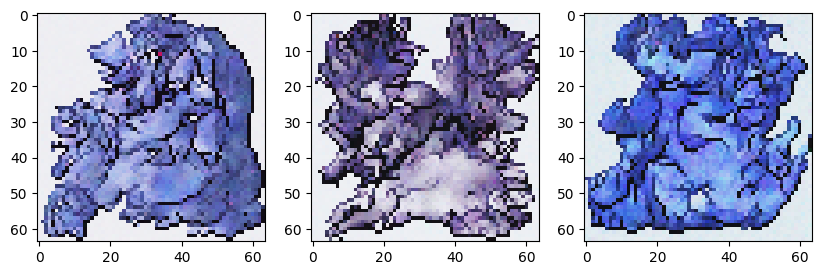

0.01846086:  46%|████▌     | 45999/100001 [1:06:17<1:16:29, 11.77it/s]

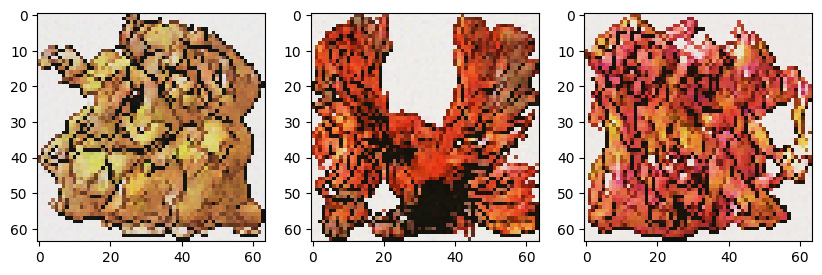

0.01047549:  47%|████▋     | 46999/100001 [1:07:43<1:15:03, 11.77it/s]

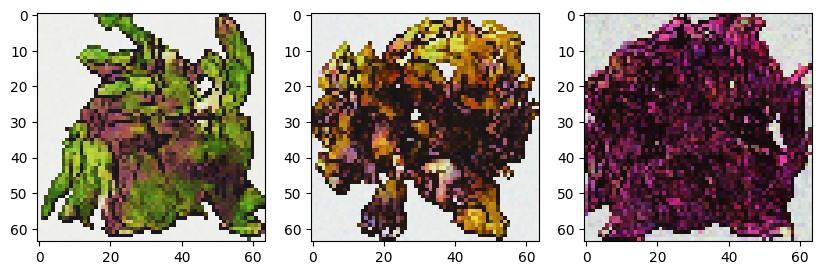

0.03376001:  48%|████▊     | 47999/100001 [1:09:09<1:13:37, 11.77it/s]

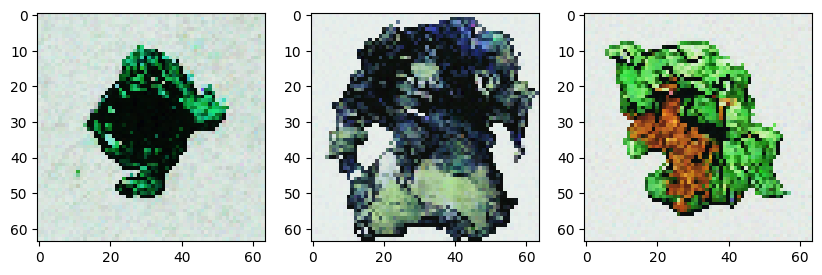

0.02591247:  49%|████▉     | 48999/100001 [1:10:36<1:12:17, 11.76it/s]

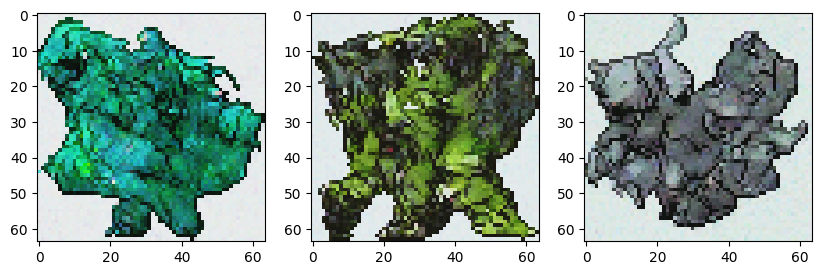

0.00889690:  50%|████▉     | 49999/100001 [1:12:02<1:10:49, 11.77it/s]

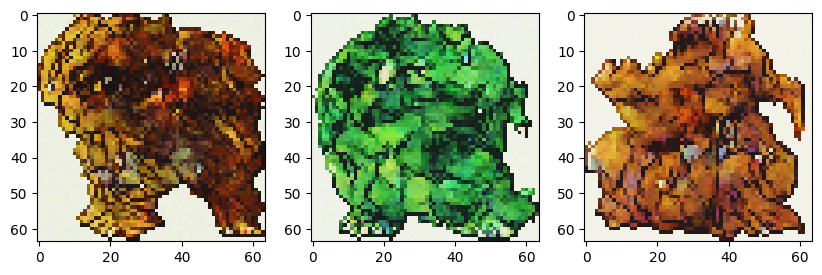

0.00596919:  51%|█████     | 50999/100001 [1:13:29<1:09:26, 11.76it/s]

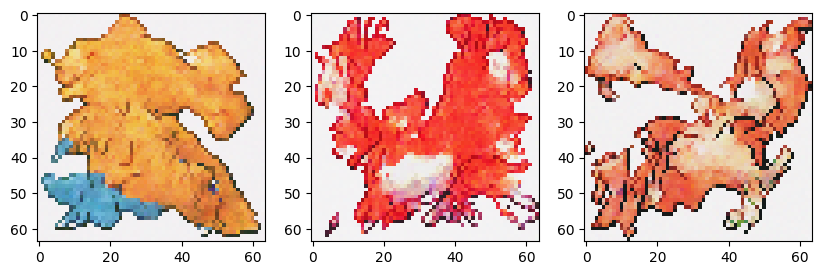

0.02751001:  52%|█████▏    | 51999/100001 [1:14:55<1:07:57, 11.77it/s]

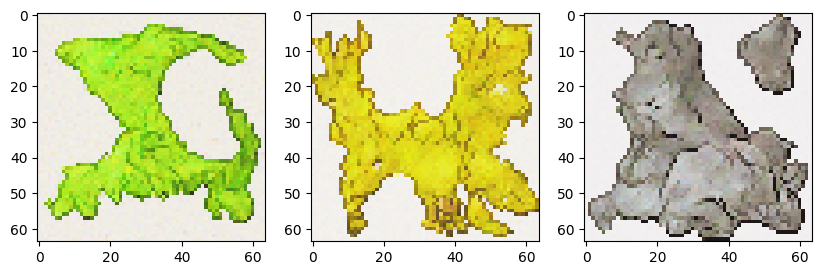

0.01743050:  53%|█████▎    | 52999/100001 [1:16:22<1:06:36, 11.76it/s]

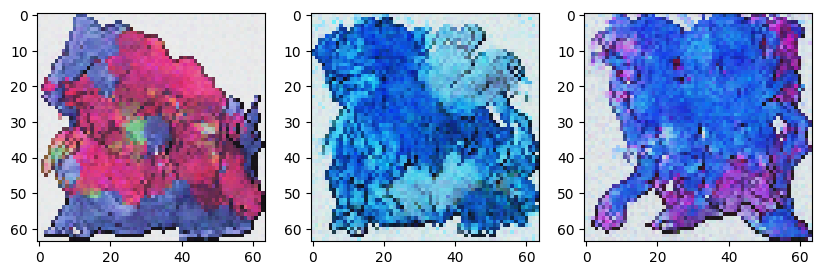

0.02043240:  54%|█████▍    | 53999/100001 [1:17:48<1:05:10, 11.76it/s]

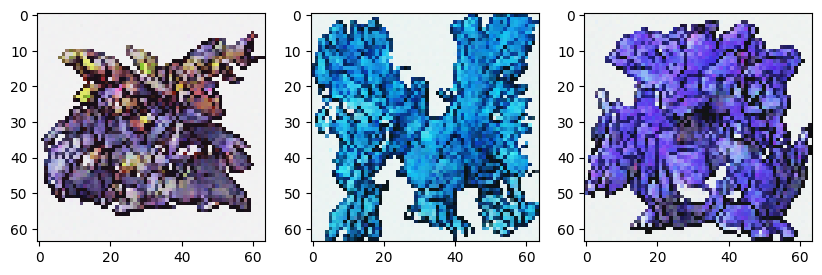

0.02469331:  55%|█████▍    | 54999/100001 [1:19:14<1:03:48, 11.75it/s]

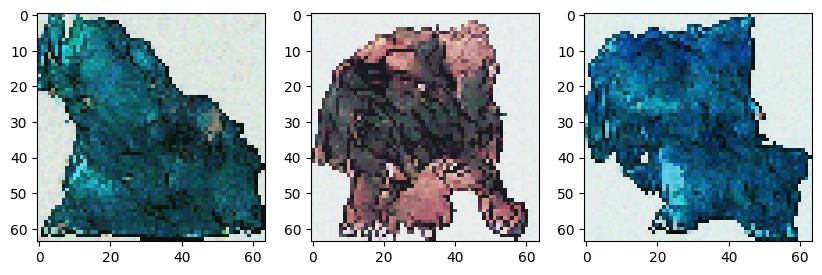

0.02511455:  56%|█████▌    | 55999/100001 [1:20:41<1:02:23, 11.76it/s]

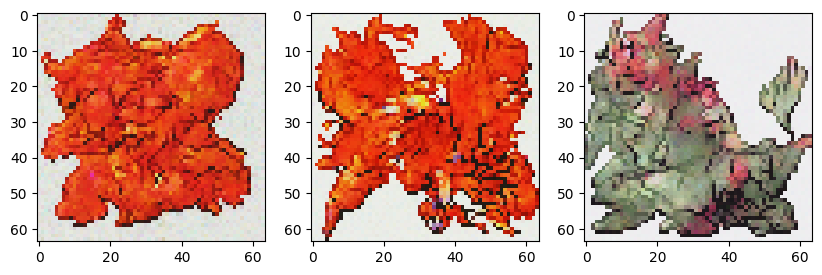

0.02185512:  57%|█████▋    | 56999/100001 [1:22:07<1:00:45, 11.80it/s]

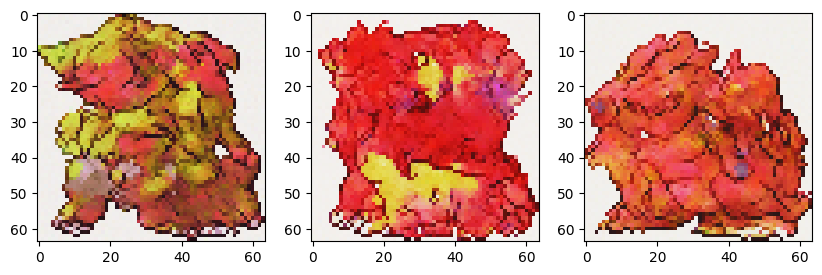

0.01185209:  58%|█████▊    | 57999/100001 [1:23:34<59:27, 11.77it/s]  

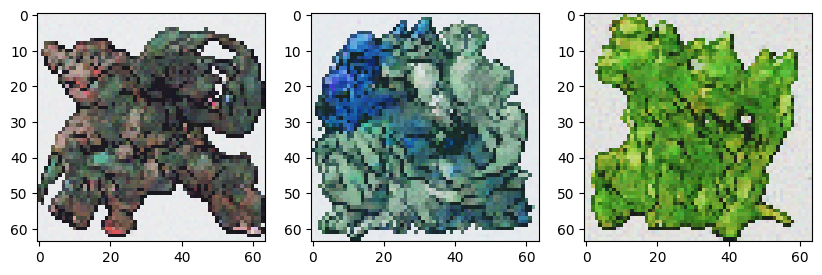

0.03163920:  59%|█████▉    | 58999/100001 [1:25:00<58:04, 11.77it/s]  

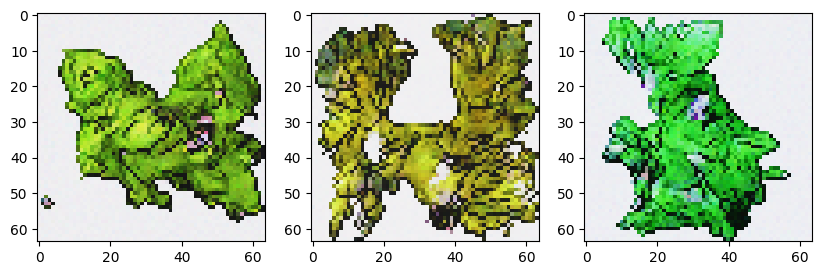

0.02385762:  60%|█████▉    | 59999/100001 [1:26:27<56:45, 11.75it/s]  

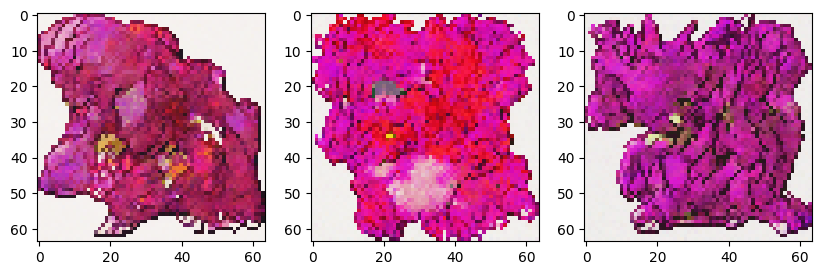

0.00865997:  61%|██████    | 60999/100001 [1:27:53<55:12, 11.77it/s]  

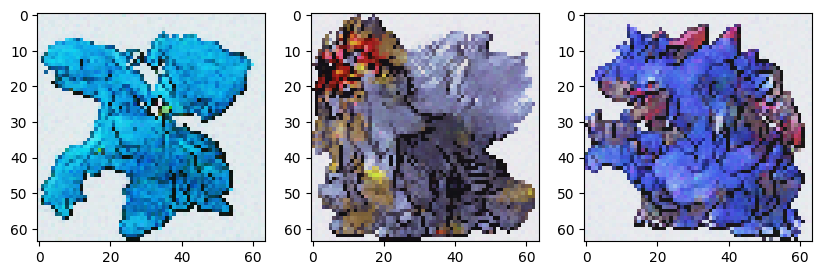

0.01425967:  62%|██████▏   | 61999/100001 [1:29:19<53:48, 11.77it/s]  

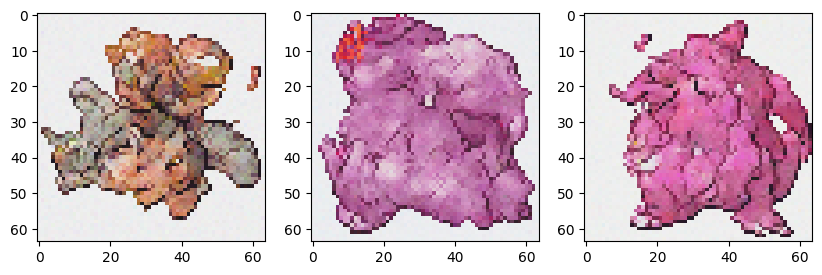

0.01259624:  63%|██████▎   | 62999/100001 [1:30:46<52:19, 11.79it/s]  

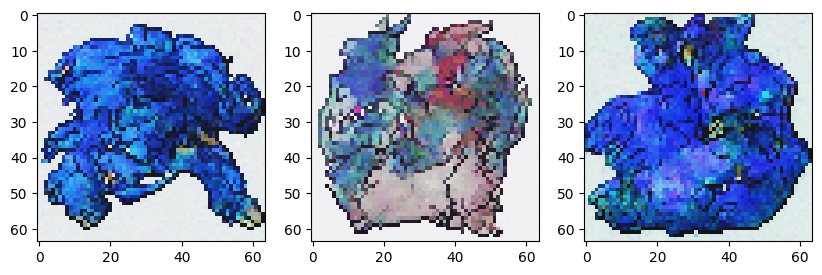

0.00902691:  64%|██████▍   | 63999/100001 [1:32:12<51:01, 11.76it/s]  

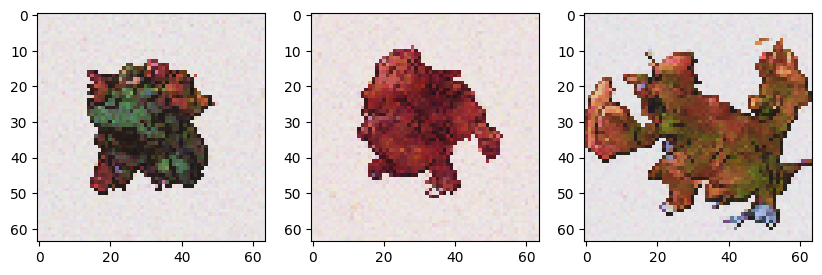

0.00978025:  65%|██████▍   | 64999/100001 [1:33:39<49:33, 11.77it/s]  

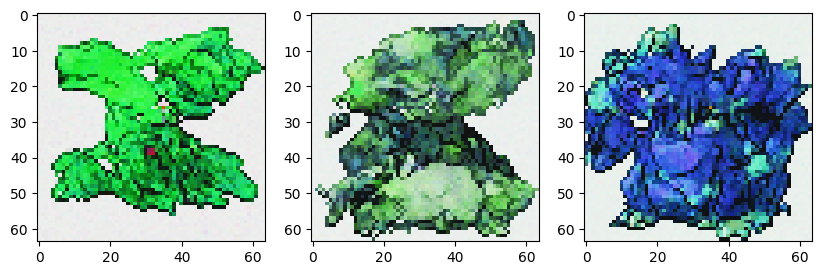

0.00640304:  66%|██████▌   | 65999/100001 [1:35:05<48:09, 11.77it/s]  

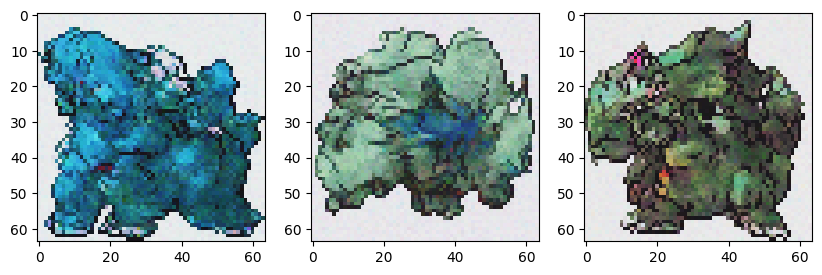

0.01033874:  67%|██████▋   | 66999/100001 [1:36:32<46:46, 11.76it/s]  

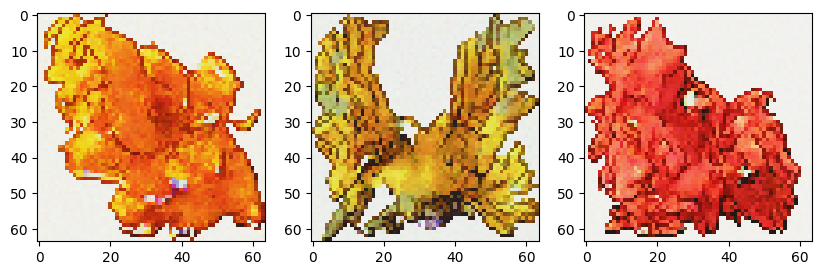

0.01692362:  68%|██████▊   | 67999/100001 [1:37:58<45:20, 11.76it/s]  

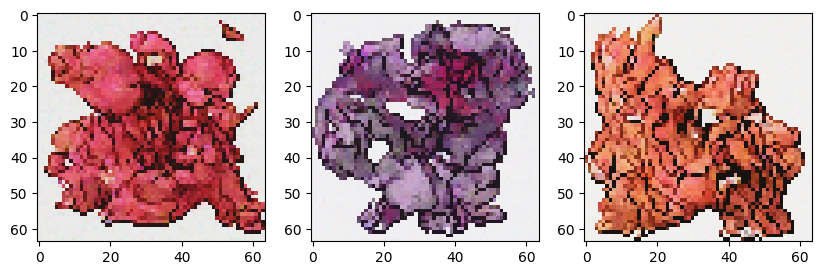

0.00958785:  69%|██████▉   | 68999/100001 [1:39:25<43:53, 11.77it/s]  

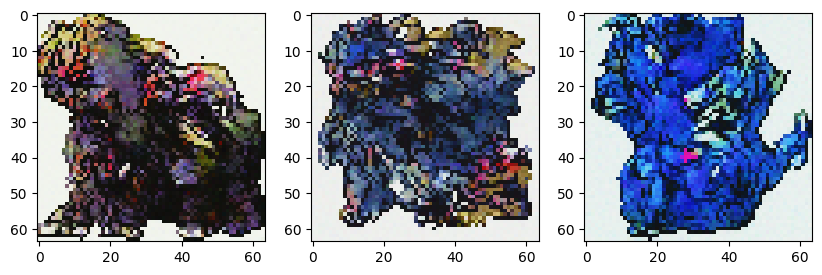

0.02077649:  70%|██████▉   | 69999/100001 [1:40:51<42:34, 11.75it/s]  

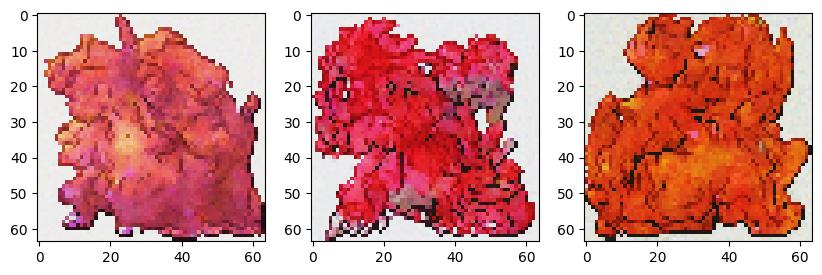

0.01291254:  71%|███████   | 70999/100001 [1:42:18<41:05, 11.76it/s]  

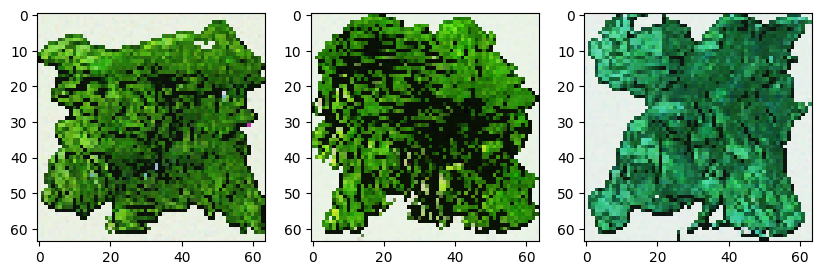

0.01697723:  72%|███████▏  | 71999/100001 [1:43:44<39:38, 11.78it/s]  

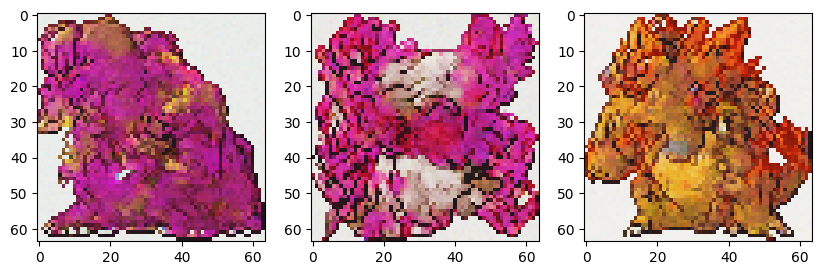

0.01516050:  73%|███████▎  | 72999/100001 [1:45:10<38:16, 11.76it/s]  

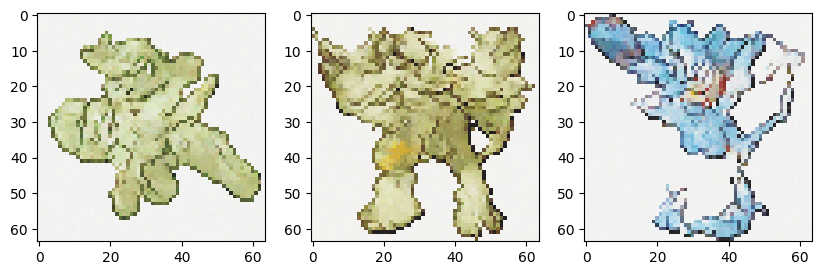

0.01042461:  74%|███████▍  | 73999/100001 [1:46:37<36:51, 11.75it/s]  

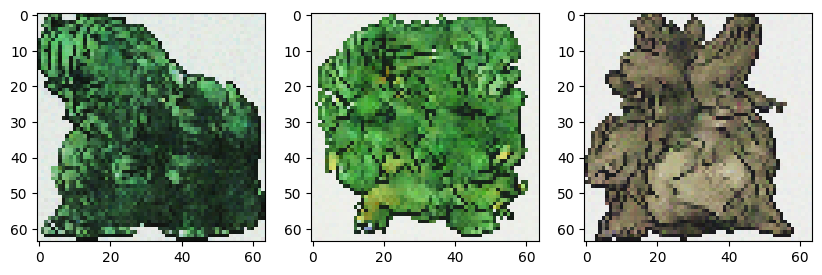

0.00875787:  75%|███████▍  | 74999/100001 [1:48:03<35:25, 11.76it/s]  

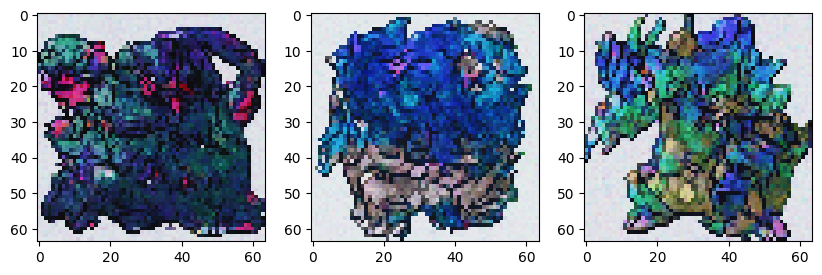

0.01204462:  76%|███████▌  | 75999/100001 [1:49:30<33:58, 11.77it/s]  

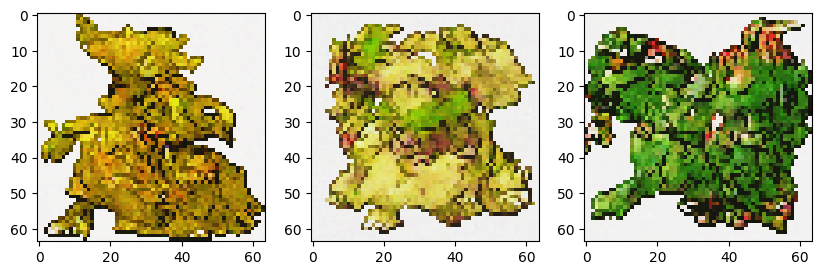

0.00847746:  77%|███████▋  | 76999/100001 [1:50:56<32:35, 11.76it/s]  

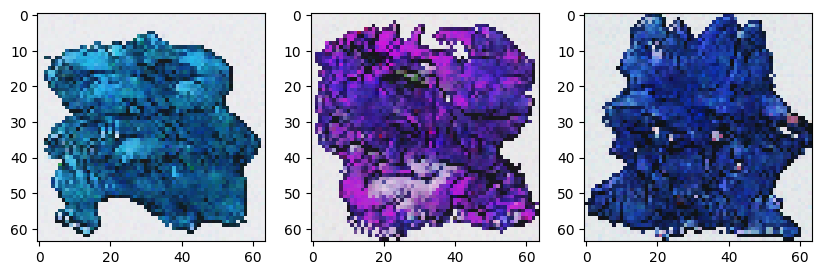

0.00593833:  78%|███████▊  | 77999/100001 [1:52:23<31:10, 11.76it/s]  

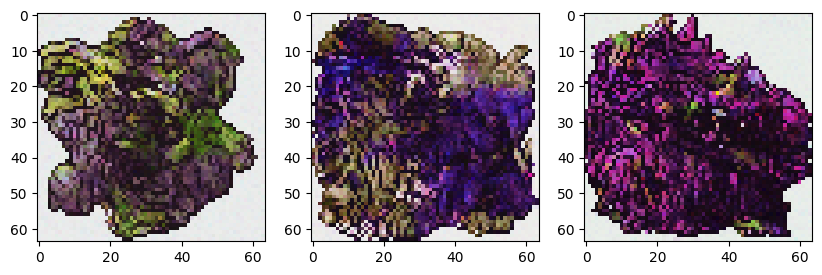

0.01661140:  79%|███████▉  | 78999/100001 [1:53:49<29:43, 11.77it/s]  

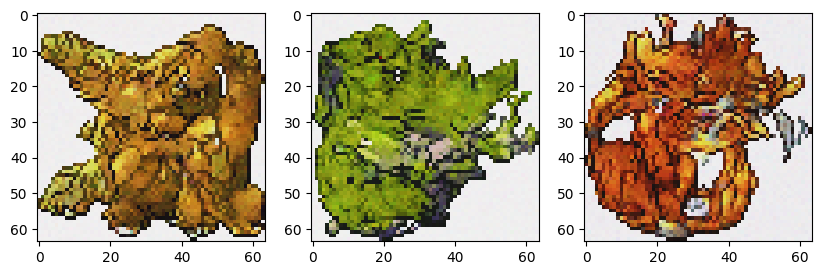

0.01332807:  80%|███████▉  | 79999/100001 [1:55:16<28:24, 11.73it/s]  

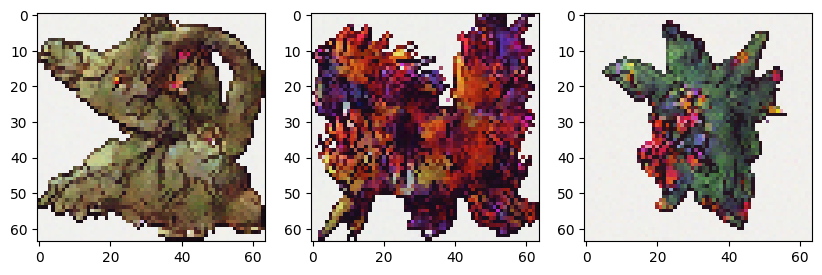

0.01002493:  81%|████████  | 80999/100001 [1:56:42<26:54, 11.77it/s]  

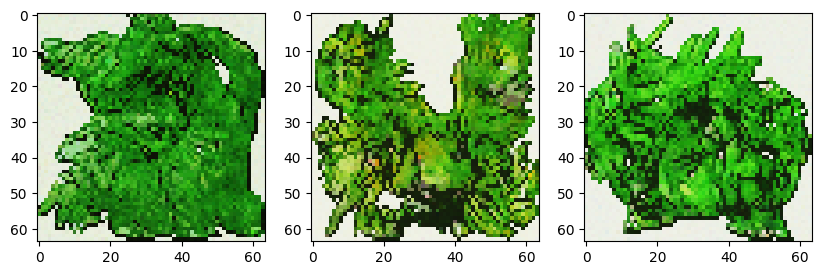

0.01140612:  82%|████████▏ | 81999/100001 [1:58:09<25:29, 11.77it/s]  

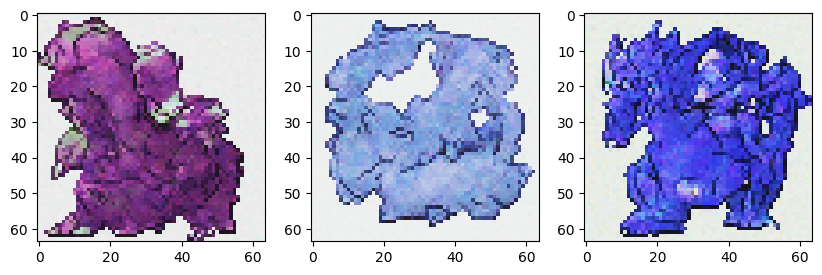

0.01545146:  83%|████████▎ | 82999/100001 [1:59:35<24:03, 11.78it/s]  

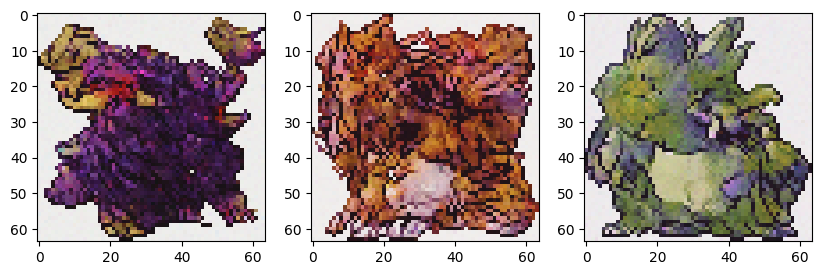

0.01440942:  84%|████████▍ | 83999/100001 [2:01:01<22:39, 11.77it/s]  

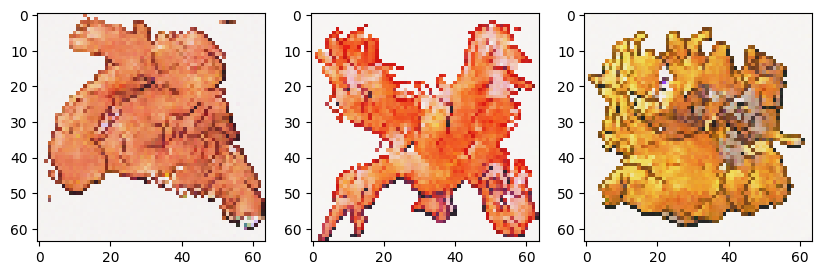

0.02542156:  85%|████████▍ | 84999/100001 [2:02:28<21:15, 11.76it/s]  

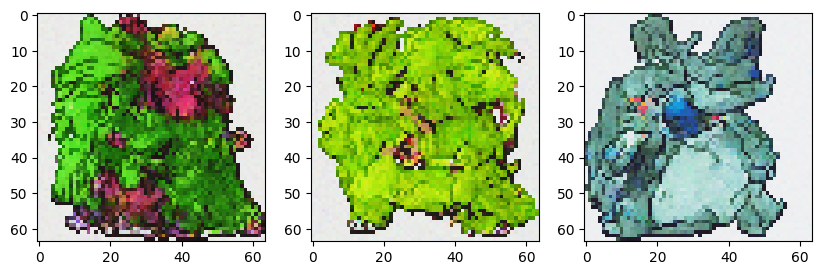

0.01165421:  86%|████████▌ | 85999/100001 [2:03:54<19:49, 11.77it/s]  

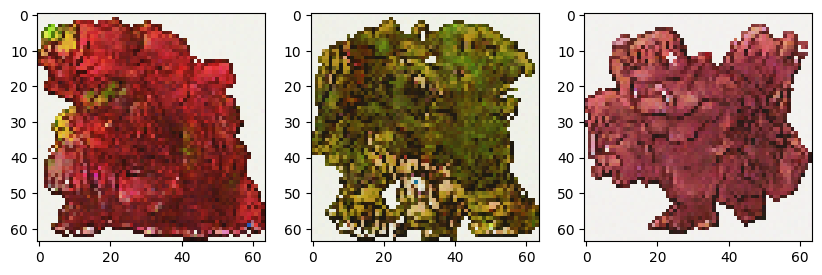

0.00916694:  87%|████████▋ | 86999/100001 [2:05:21<18:25, 11.76it/s]  

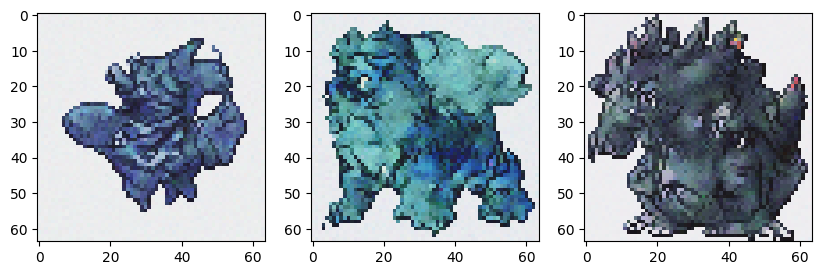

0.01485092:  88%|████████▊ | 87999/100001 [2:06:47<17:01, 11.75it/s]  

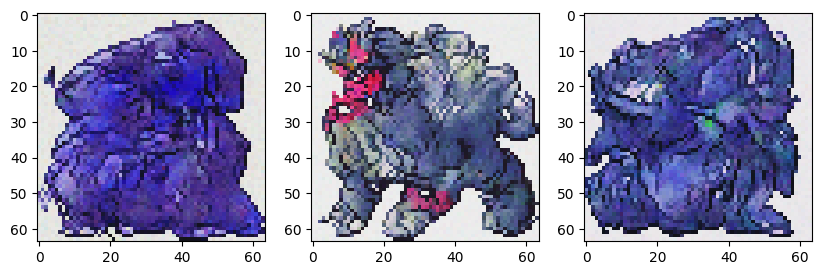

0.01843798:  89%|████████▉ | 88999/100001 [2:08:14<15:35, 11.76it/s]  

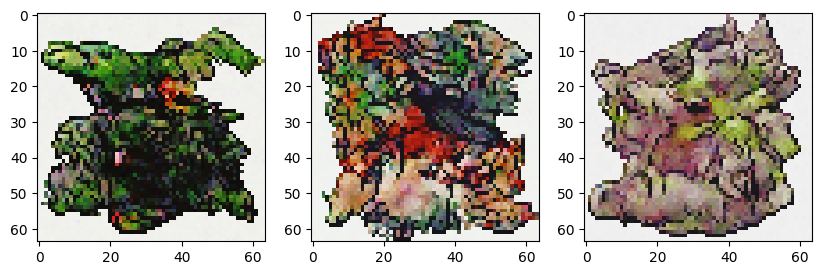

0.01551217:  90%|████████▉ | 89999/100001 [2:09:40<14:09, 11.77it/s]

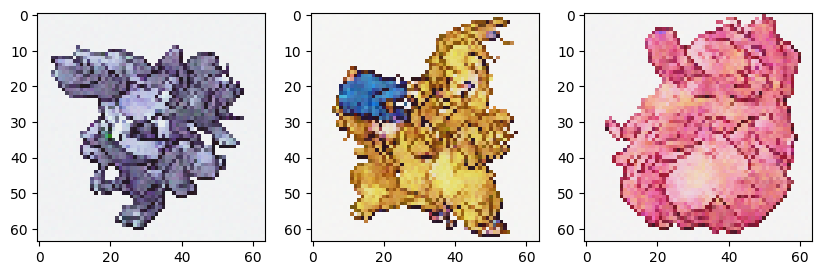

0.01665290:  91%|█████████ | 90999/100001 [2:11:07<12:44, 11.78it/s]

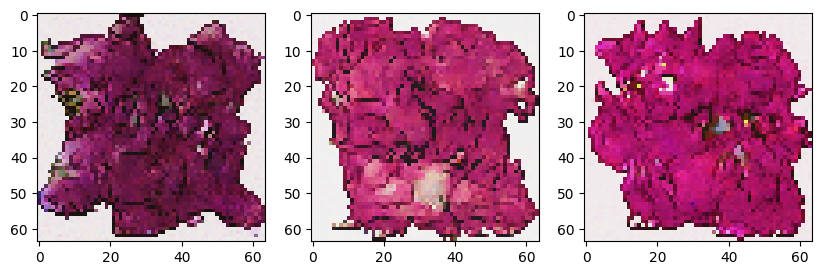

0.01139024:  92%|█████████▏| 91999/100001 [2:12:33<11:20, 11.77it/s]

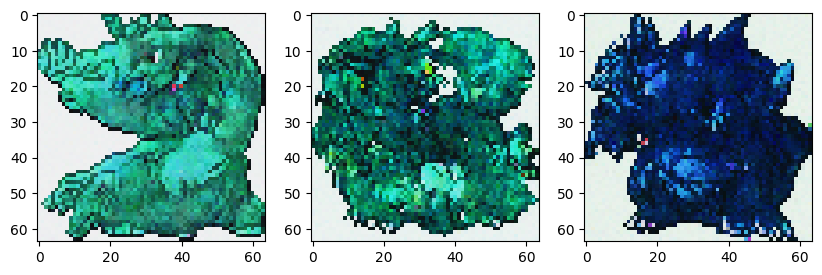

0.00836700:  93%|█████████▎| 92999/100001 [2:14:00<09:55, 11.76it/s]

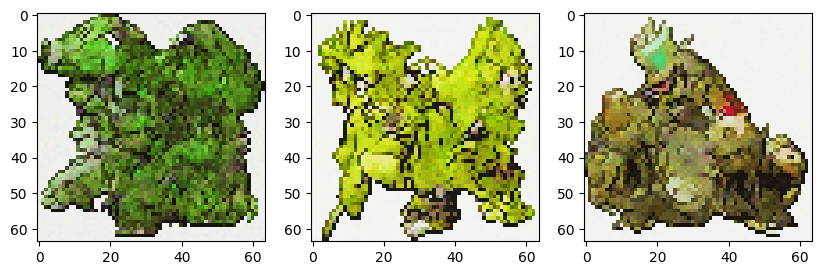

0.01174690:  94%|█████████▍| 93999/100001 [2:15:26<08:28, 11.81it/s]

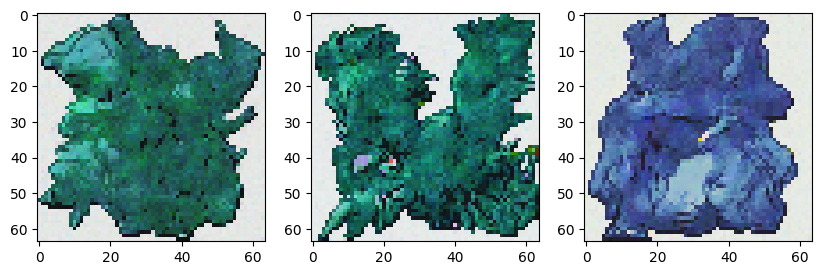

0.01614193:  95%|█████████▍| 94999/100001 [2:16:53<07:05, 11.76it/s]

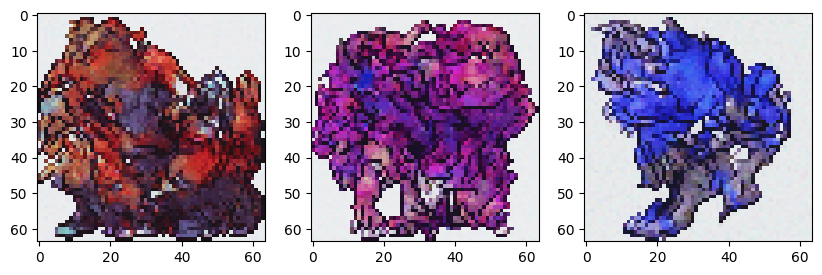

0.00804558:  96%|█████████▌| 95999/100001 [2:18:19<05:40, 11.76it/s]

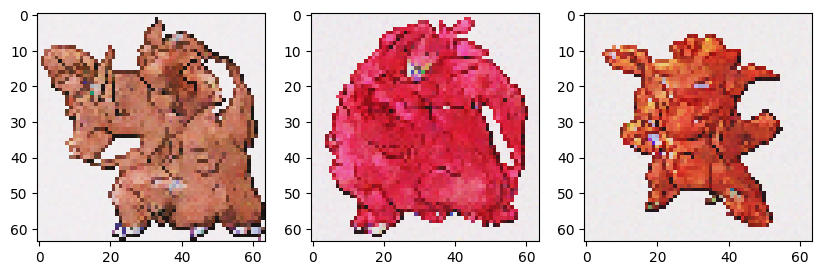

0.01443585:  97%|█████████▋| 96999/100001 [2:19:45<04:15, 11.76it/s]

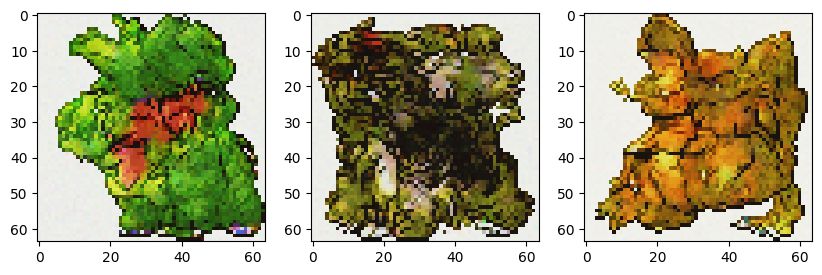

0.01318975:  98%|█████████▊| 97999/100001 [2:21:12<02:50, 11.77it/s]

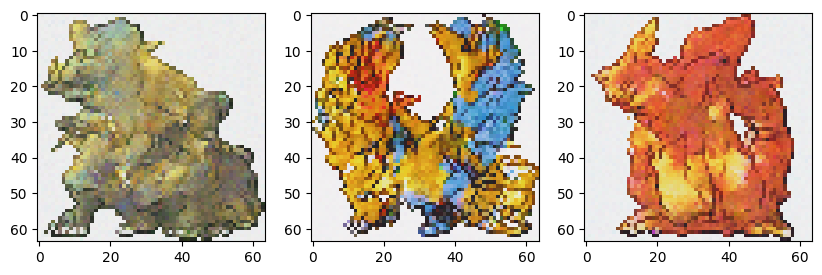

0.01898108:  99%|█████████▉| 98999/100001 [2:22:38<01:25, 11.78it/s]

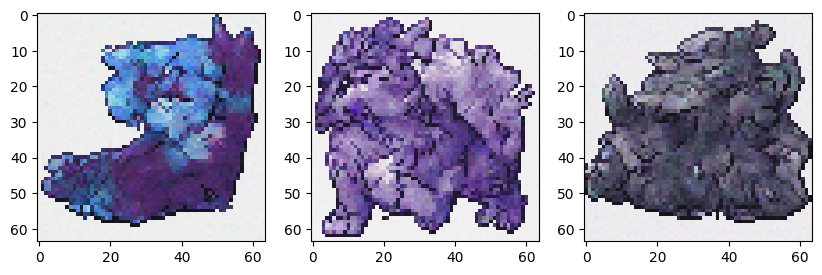

0.02019737: 100%|█████████▉| 99999/100001 [2:24:05<00:00, 11.76it/s]

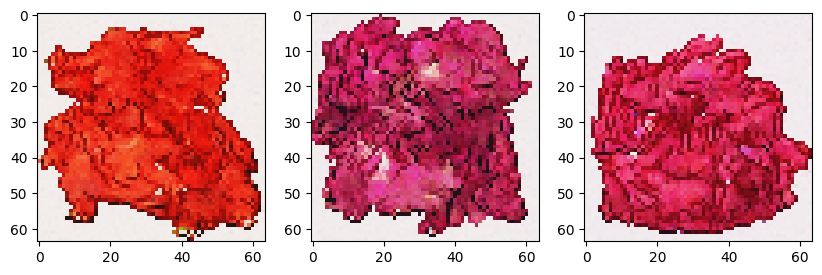

0.01596352: 100%|██████████| 100001/100001 [2:24:06<00:00, 11.56it/s]


In [8]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
pbar = tqdm(range(100001))
def closure():
    optimizer.zero_grad()

    bs = 8

    source = randint(0, 2)
    batch = torch.randperm(385)[:bs]
    x0 = pimages[source, batch]
    x0 = torch.stack([transform(x) for x in x0], dim=0)
    x0 = isigmoid(x0)

    ty = types[batch]

    e = torch.randn_like(x0)
    t = torch.randint(0, T - 1, (bs,), device=device)

    xt = torch.sqrt(alpha_[t])[:, None, None, None] * x0 + torch.sqrt(1-alpha_[t])[:, None, None, None] * e
    ep = model(xt, t, ty)

    loss = loss_func(ep, e)
    loss.backward()
    
    pbar.set_description(f"%.8f" % loss, refresh=False)
    
    return loss

model.train()
for j in pbar:
    optimizer.step(closure)

    if j % 1000 == 0:
        generate_image()

torch.save(model.state_dict(), 'model.pt')